In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from moviepy.editor import VideoFileClip
import cv2
%matplotlib inline

In [61]:
def show_images(images,cmap=None):
  """
  This function displays the input images in from the test images
  """

  fig = plt.figure(figsize=(10,10))
  for i, image in enumerate(images):
    if i < 10:
      plt.subplot(5,3,i+1)
      if len(image.shape)==2:
        cmap="gray"
      plt.imshow(image,cmap=cmap)
      plt.xticks([])
      plt.yticks([])
  plt.show()

In [62]:
images = [plt.imread(image) for image in glob.glob("/content/outputs/*.jpg")]

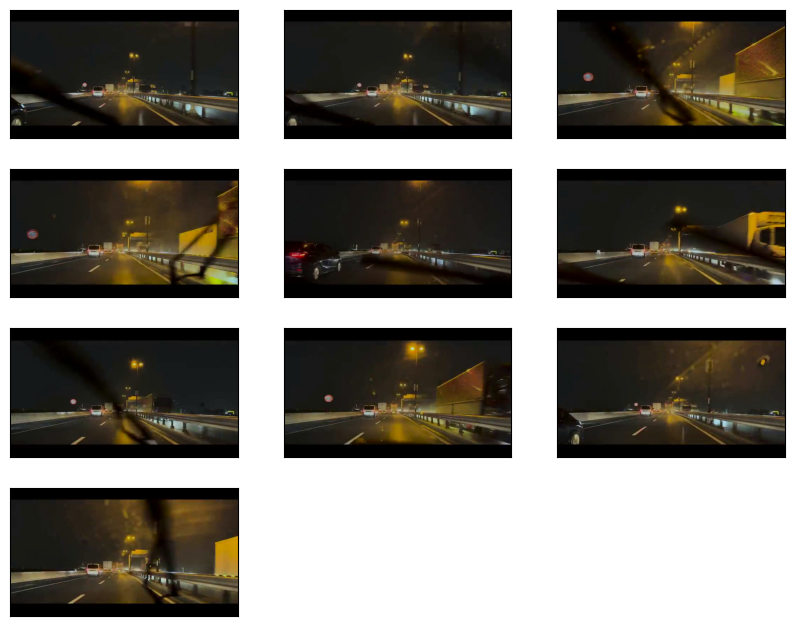

In [64]:
show_images(images)

In [65]:
# Canny Edge detection (uses gradient to find posiition, magniture and orientation of the edge and lapplacian with respect to the direction of orientation)

# Firstly We need to grayscale the image

def gray_image(image):
  """
  Takes the image as input and returns the gray scale output of the image
  """

  return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

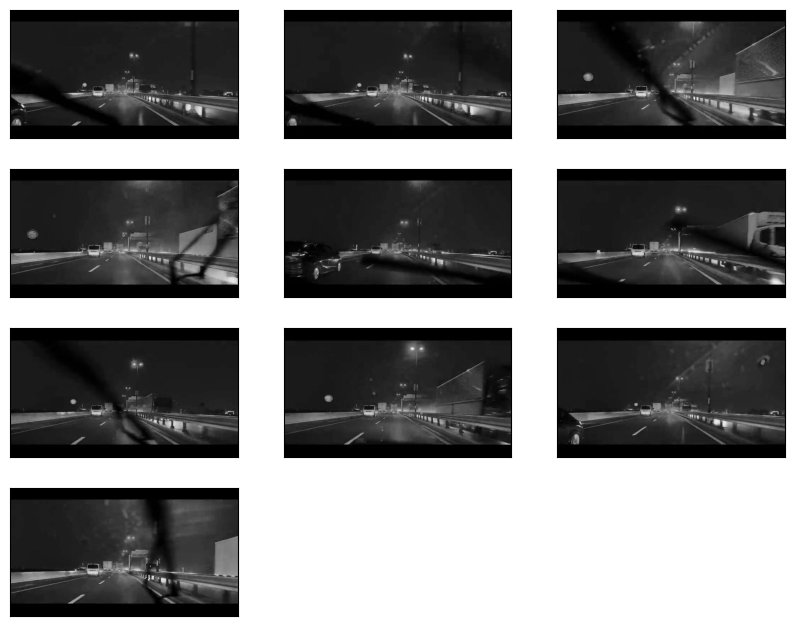

In [66]:
show_images(list(map(gray_image,images)))

In [67]:
# RGB color selection
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    # White color mask
    lower_threshold = np.uint8([50, 50, 50])  # Adjusted lower threshold for white
    upper_threshold = np.uint8([255, 255, 255])  # Adjusted upper threshold for white
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)

    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)


    mask = cv2.bitwise_or(white_mask,yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask=white_mask)

    return masked_image


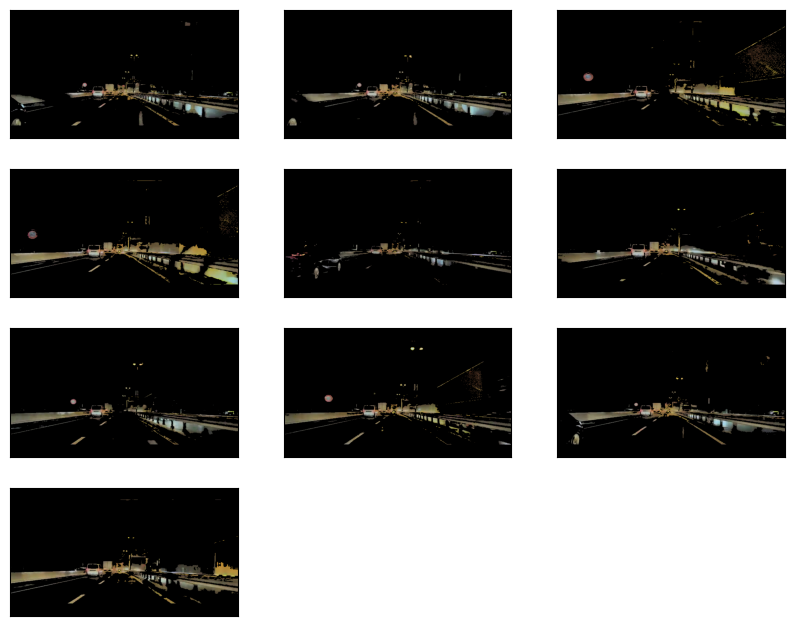

In [68]:
show_images(list(map(RGB_color_selection,images)))


In [17]:
color_selected_images = list(map(RGB_color_selection,images))

In [18]:
# Canny Edge detection
gray_images = list(map(gray_image,color_selected_images))

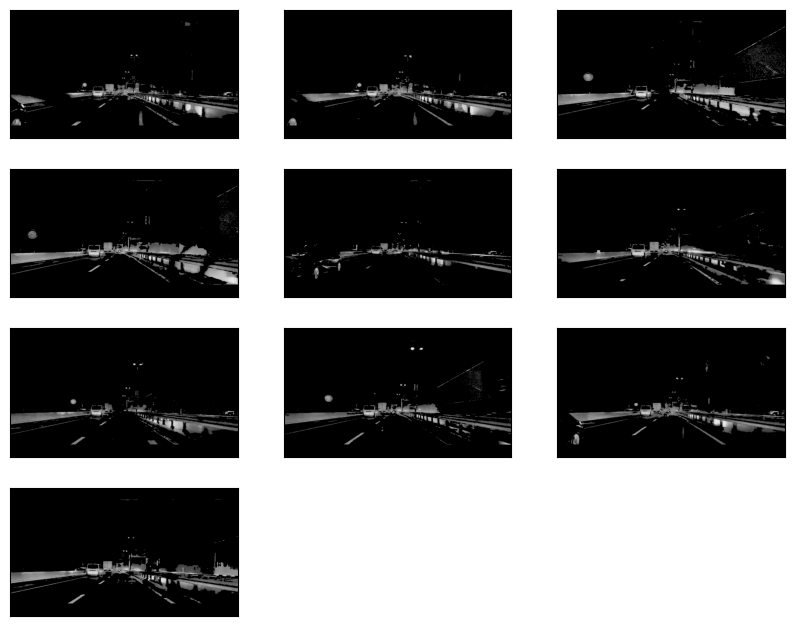

In [19]:
show_images(gray_images)

In [20]:
# Applying gaussian smoothing

def gaussian_smoothing(image,kernel_size=13):
  return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)

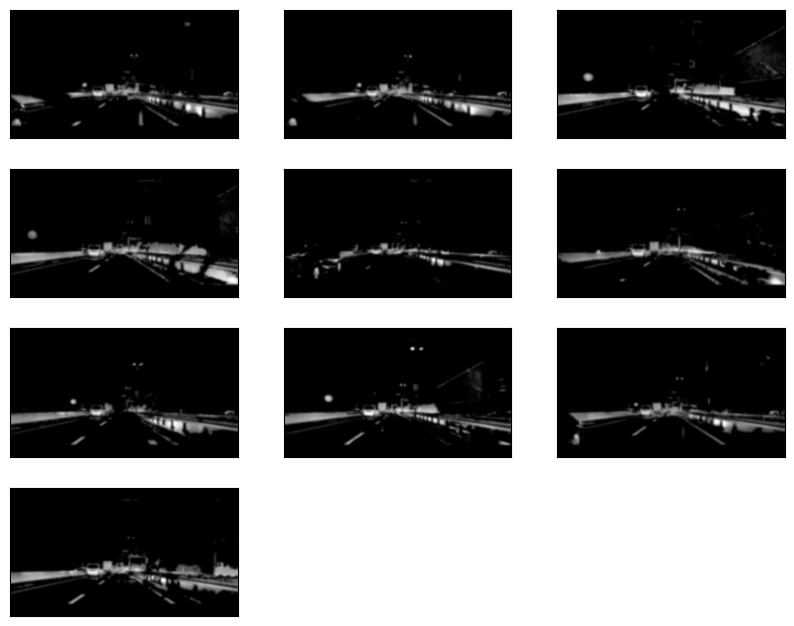

In [21]:
blur_images = list(map(gaussian_smoothing,gray_images))
show_images(blur_images)

In [22]:
# Applying Canny Edge Detection

def canny_detector(image,low_threshold=0,high_threshold=150):
  """
  Apply canny edge detection algorithm to the input image.
  """
  return cv2.Canny(image,low_threshold,high_threshold)

def gradient_edge_detection(image):
    # Check if the input image is grayscale
    if len(image.shape) == 2:
        # If the image is grayscale, do not convert it to grayscale again
        gray = image
    else:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Sobel operator for horizontal and vertical gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the magnitude of the gradient
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalize the magnitude to the range [0, 255]
    magnitude_normalized = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return magnitude_normalized

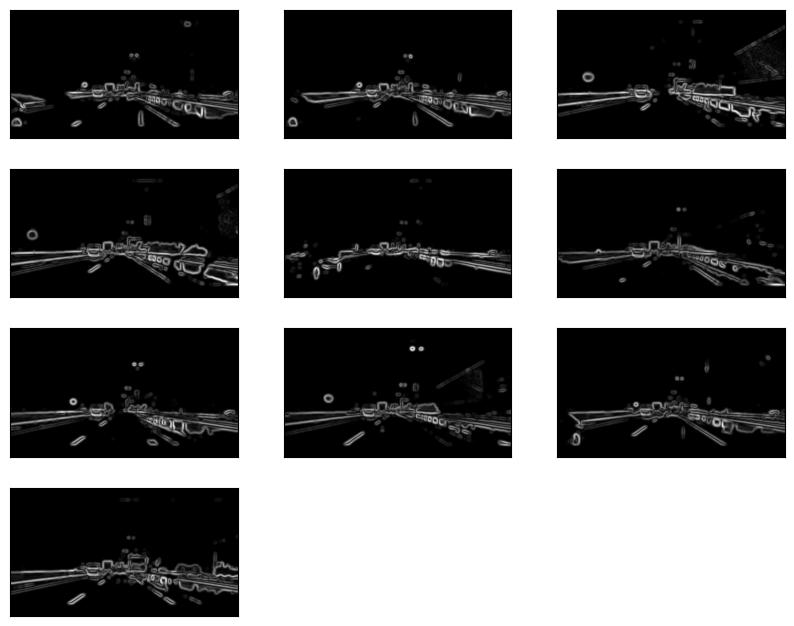

In [23]:
edge_detected_images = list(map(gradient_edge_detection,blur_images))
show_images(edge_detected_images)

In [24]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    mask = np.zeros_like(image)
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.7]
    bottom_right = [cols * 0.95, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.7]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

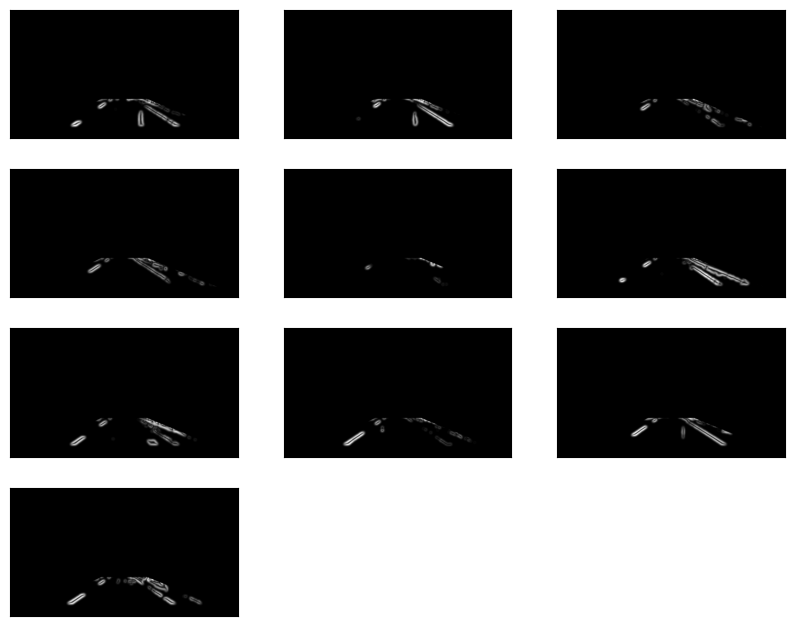

In [25]:
masked_image = list(map(region_selection, edge_detected_images))
show_images(masked_image)

In [27]:
import cv2
import numpy as np

def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: The output of a Canny transform.
    """
    rho = 1              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 15       #Only lines that are greater than threshold will be returned.
    minLineLength = 40   #Line segments shorter than that are rejected.
    maxLineGap = 20     #Maximum allowed gap between points on the same line to link them

    # Perform Hough transform
    hough_lines = cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold,
                                   minLineLength=minLineLength, maxLineGap=maxLineGap)

    # Check if hough_lines is None
    if hough_lines is None:
        return []  # Return an empty list if no lines are detected

    return hough_lines


In [28]:
hough_lines = list(map(hough_transform, masked_image))


In [29]:
def draw_lines(image, lines, color = [0, 0, 128], thickness = 1):
    """
    Draw lines onto the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            lines: The lines we want to draw.
            color (Default = red): Line color.
            thickness (Default = 2): Line thickness.
    """
    image = np.copy(image)
    if len(lines) != 0:
      for line in lines:
          for x1,y1,x2,y2 in line:
              cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

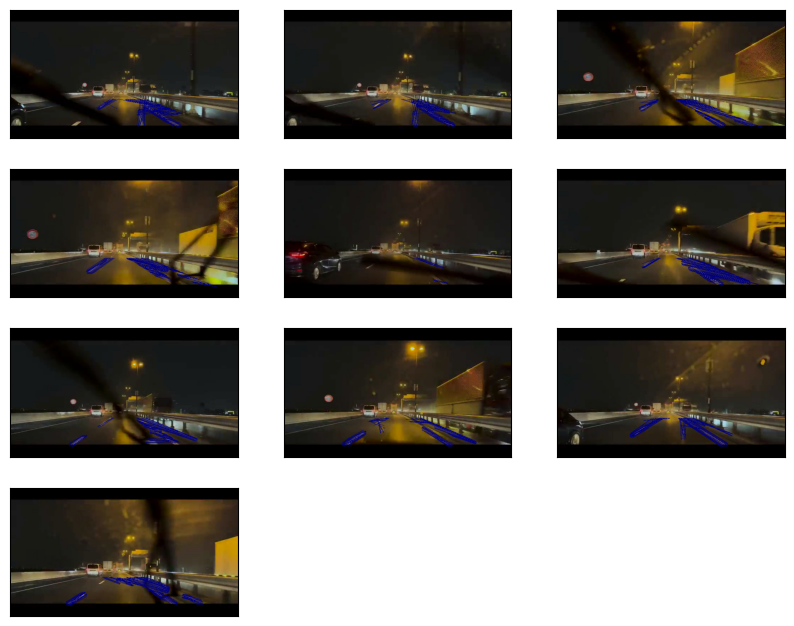

In [30]:
line_images = []
for image, lines in zip(images, hough_lines):
    line_images.append(draw_lines(image, lines))

show_images(line_images)

In [31]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
        Parameters:
            lines: The output lines from Hough Transform.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)

    if lines is None or len(lines) == 0:  # Check if lines is None or empty
        return None
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [32]:
def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

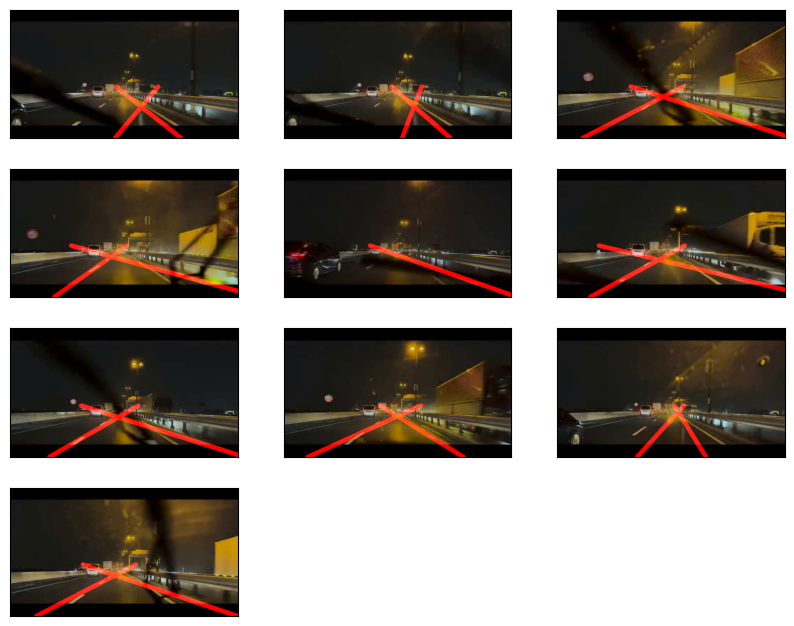

In [33]:
def lane_lines(image, lines):
    """
    Create full lenght lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    if (average_slope_intercept(lines)) != None:
      left_lane, right_lane = average_slope_intercept(lines)
      y1 = image.shape[0]
      y2 = y1 * 0.6
      left_line  = pixel_points(y1, y2, left_lane)
      right_line = pixel_points(y1, y2, right_lane)
      return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
            color (Default = red): Line color.
            thickness (Default = 12): Line thickness.
    """
    line_image = np.zeros_like(image)
    if lines is None or len(lines) == 0:  # Check if lines is None or empty
        return None
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

lane_images = []
for image, lines in zip(images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))


show_images(lane_images)

In [5]:
def save_frames(video_path, output_dir):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Create the output directory if it doesn't exist
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Loop through the video frames
    frame_count = 0
    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        # If the frame was not read successfully or end of video is reached, break the loop
        if not ret:
            break

        # Convert pixel values to standard 0-255 range (assuming they are in a different range)
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

        # Save the frame in JPG format
        cv2.imwrite(f"{output_dir}/frame_{frame_count:04d}.jpg", frame)

        frame_count += 1

    # Release the video capture object
    cap.release()
    print(f"Frames saved: {frame_count} out of {total_frames}")

# Example usage
video_path = "/content/sample_data/test.mp4"  # Replace with your video file path
output_dir = "outputs"    # Directory to save the frames
save_frames(video_path, output_dir)


Frames saved: 137 out of 178


In [59]:
import os
from moviepy.editor import VideoFileClip

def process_video(input_video, output_video):
    """
    Process input video using frame_processor and save the processed video.
    Parameters:
        input_video (str): Path to the input video file.
        output_video (str): Path to save the processed video file.
    """
    def frame_processor(image):
        """
        Process the input frame to detect lane lines.
        """
        color_select = RGB_color_selection(image)
        gray         = gray_image(color_select)
        smooth       = gaussian_smoothing(gray)
        edges        = canny_detector(smooth)
        region       = region_selection(edges)
        hough        = hough_transform(region)
        result       = draw_lane_lines(image, lane_lines(image, hough))
        if result is None:
            # If processed_frame is None, return a placeholder frame
            # You can return a black frame, a copy of the input frame, or any suitable placeholder
            return np.zeros_like(image)
        return result


    input_clip = VideoFileClip(input_video)


    processed_clip = input_clip.fl_image(frame_processor)


    processed_clip.write_videofile(output_video, codec='libx264', audio=False)

input_video_path = "/content/sample_data/test.mp4"
output_video_path = "output_videos.mp4"
process_video(input_video_path, output_video_path)


Moviepy - Building video output_videos.mp4.
Moviepy - Writing video output_videos.mp4



Moviepy - Done !
Moviepy - video ready output_videos.mp4
